# Recognize US Dollar Bills (v2)

Use Convolutional Neural Nets and Transfer Learning to train a model to classify a US dollar bill



### Imports

In [1]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/backend.py:5879: ResourceWarning: unclosed file <_io.TextIOWrapper name='/root/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))


Tensorflow Version: 2.1.0


### 1. Load the Data
The dataset is in the imagenet format and consists of multiple folders, where each folder is a class containing images related to that class

In [2]:
# _URL = 'https://<path_for_data_server>/data.zip'

# zip_dir = tf.keras.utils.get_file('data.zip', origin=_URL, extract=True, cache_dir='/storage/data/')

In [3]:
# get the location of downloaded zip file and then join it with the name of extracted folder name
zip_dir = "/storage/data/datasets/us-bills-data.zip"
data_dir = pathlib.Path.joinpath(pathlib.Path(zip_dir).parent, "us-bills-data")
print(data_dir)

/storage/data/datasets/us-bills-data


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Number of images = {image_count}")

Number of images = 182


In [5]:
# get the names of classes as a list
image_classes = np.array([item.name for item in data_dir.glob('*')])
print(f"Image Classes = {image_classes}")

Image Classes = ['USD-10' 'Other' 'USD-50' 'USD-5' 'USD-20' 'USD-1' 'USD-100']


### 2. Load images using Keras

- Resize to `224x224`
- Get image in batches of size `16`
- Scale the image pixel values `between [0,1]`
- Augment the training images
    - rotation_range = 40
    - horizontal_flip = True
    - width_shift_range = 0.2
    - height_shift_range = 0.2
    - shear_range = 0.2
    - zoom_range = 0.2
    - allow shuffling


#### 2.1 Data Augmentation
Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In [6]:
IMAGE_SIZE = (224, 224) # height, width
BATCH_SIZE = 16

In [7]:
datagen_args = dict(rescale=1./255,
                    validation_split=0.20)
dataflow_args = dict(target_size=IMAGE_SIZE,
                     batch_size=BATCH_SIZE,
                     interpolation='bilinear')

In [8]:
# Validation data generator and flow
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_args)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, 
    subset="validation", 
    shuffle=False, 
    **dataflow_args)

# Train data generator, with augmentation and train flow
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=45,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_args)
train_generator = train_datagen.flow_from_directory(
    data_dir, 
    subset="training", 
    shuffle=True, 
    **dataflow_args)

Found 34 images belonging to 7 classes.
Found 149 images belonging to 7 classes.


### 3. Visualize the training images

Visualize one batch, i.e., 16 images, of the training set from the training generator

In [9]:
# First let's get the indices assigned to each class labels for reference
train_generator.class_indices

{'Other': 0,
 'USD-1': 1,
 'USD-10': 2,
 'USD-100': 3,
 'USD-20': 4,
 'USD-5': 5,
 'USD-50': 6}

In [10]:
visualize_train_images, visualize_train_labels  = next(train_generator)

The `next` function returns a batch from the dataset. The return value of next function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels.

In [11]:
# Inspect the shape of the batch of data
print(f"Shape of 1 image batch = {visualize_train_images.shape}")
print(f"Shape of 1 image batch = {visualize_train_labels.shape}")

Shape of 1 image batch = (16, 224, 224, 3)
Shape of 1 image batch = (16, 7)


In [12]:
# This function will plot images in the form of a grid with 1 row and 6 columns
def plotImages(images_arr,images_label):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, images_label, axes):
        ax.imshow(img)
        ax.set_title(lbl)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


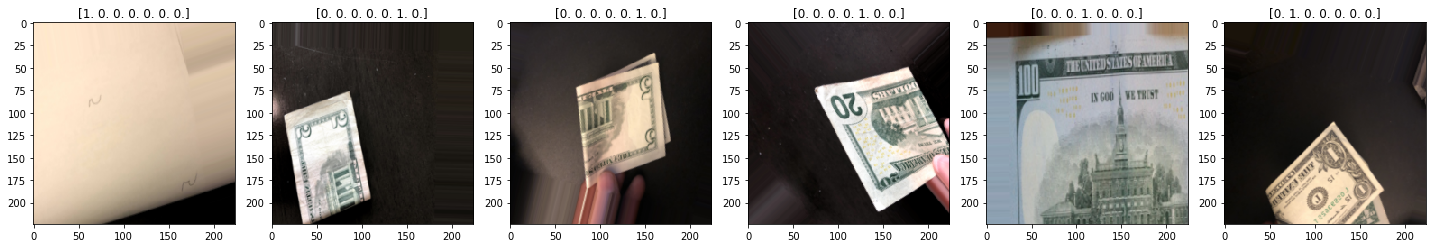

In [13]:
plotImages(visualize_train_images[:6], visualize_train_labels[:6])

Our labels are one-hot encoded, so we'll use `categorical_cross_entropy` for model loss, as opposed to `sparse_categorical_cross_entropy`, which is used if each class corresponded to a single number

### 4. Creating and Training a Simple CNN Sequential Model

#### With Batchnorm training was very bad. Val_loss was increasing instead of decreasing so had to switch to not using it.

In [35]:
tf.keras.backend.clear_session()

simple_cnn_input = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), name='input_img')
x = tf.keras.layers.Conv2D(16, 3, activation='relu')(simple_cnn_input)
x = tf.keras.layers.MaxPooling2D(2)(x)
# x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
# x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
# x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
# x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
simple_cnn_output = tf.keras.layers.Dense(7, activation='softmax')(x)

cnn_model = tf.keras.Model(simple_cnn_input, simple_cnn_output, name='simple_cnn_model')

cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
cnn_model.summary()

Model: "simple_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)   

In [36]:
CNN_MODEL_EPOCHS = 100
CALLBACK_EARLY_STOP = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                       min_delta=1e-2,
                                                       verbose=1)
CALLBACK_MODEL_CHKPOINT = tf.keras.callbacks.ModelCheckpoint(filepath='/storage/models/usbills-simple-cnn-v2-model',
                                                             save_best_only=True,
                                                             verbose=1)

STEPS_PER_EPOCH = train_generator.samples // train_generator.batch_size
VALIDATION_STEPS = valid_generator.samples // valid_generator.batch_size

In [37]:
cnn_model_history = cnn_model.fit(train_generator,
                    epochs=CNN_MODEL_EPOCHS,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_data=valid_generator,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[CALLBACK_EARLY_STOP, CALLBACK_MODEL_CHKPOINT])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 9 steps, validate for 2 steps
Epoch 1/100
8/9 [=========================>....] - ETA: 2s - loss: 1.9674 - accuracy: 0.1368
Epoch 00001: val_loss improved from inf to 1.91623, saving model to /storage/models/usbills-simple-cnn-v2-model
INFO:tensorflow:Assets written to: /storage/models/usbills-simple-cnn-v2-model/assets
9/9 [==============================] - 27s 3s/step - loss: 1.9615 - accuracy: 0.1429 - val_loss: 1.9162 - val_accuracy: 0.2188
Epoch 2/100
8/9 [=========================>....] - ETA: 2s - loss: 1.8882 - accuracy: 0.2393
Epoch 00002: val_loss improved from 1.91623 to 1.84992, saving model to /storage/models/usbills-simple-cnn-v2-model
INFO:tensorflow:Assets written to: /storage/models/usbills-simple-cnn-v2-model/assets
9/9 [==============================] - 27s 3s/step - loss: 1.8679 - accuracy: 0.2331 - val_loss: 1.8499 - val_accuracy: 0.1250
Epoch 3/100
8/9 [=========================>....] - ETA: 2s - loss: 1.8

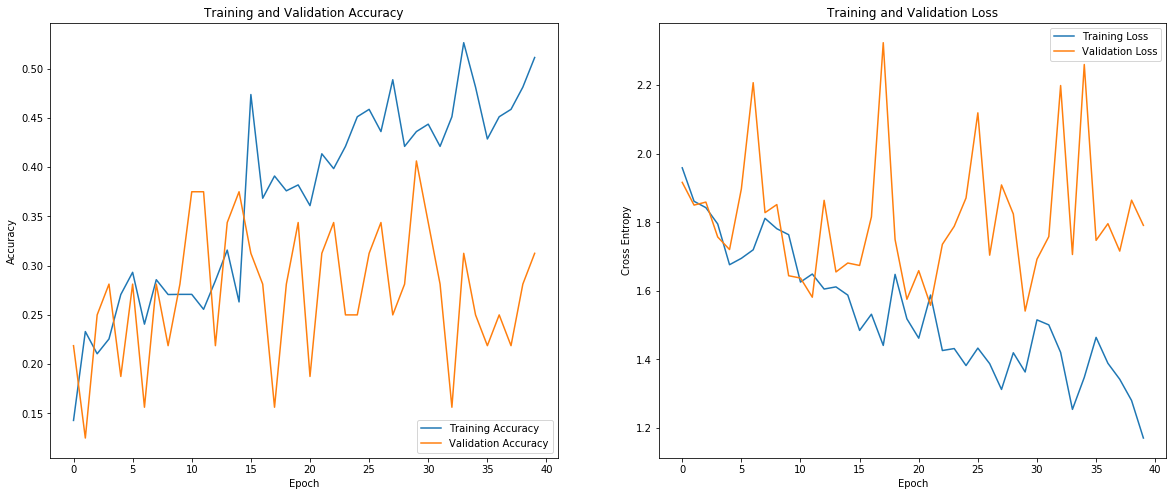

In [38]:
acc = cnn_model_history.history['accuracy']
val_acc = cnn_model_history.history['val_accuracy']

loss = cnn_model_history.history['loss']
val_loss = cnn_model_history.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

#### Takeaways from these plots

* The model is trying hard to learn from the small amount of data
* We are using both EarlyStopping and ModelCheckpoint callbacks for training which are set to monitor the `val_loss`
* Although the number of initial epochs are set to 100, but the around `epoch=30` the *validation loss starts increasing* which indicates that the model is starting to overfit from that point onwards. The best model, at this point is saved.
* Not a good model to use in production

> **How to improve?**
> * add more data
> * try using *Transfer Learning* with a pre-trained model like MobileNet, ResNet or Inception
> * apply CAM and/or gradCAM to understand what is the model looking at in the images





### 4. Creating and Training a model using TransferLearning

We'll use Resnet50 model as the base model with the `imagenet` weights

In [18]:
IMAGE_SHAPE = (IMAGE_SIZE[0],IMAGE_SIZE[1],3) # RGB image with 3 channels (224x224x3)

# Create the base model with pre-trained Resnet50 V2
base_model = tf.keras.applications.ResNet50V2(input_shape=IMAGE_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [19]:
feature_batch = base_model(visualize_train_images)
print(f"Shape of extracted features on 1 batch from the base model = {feature_batch.shape}")

Shape of extracted features on 1 batch from the base model = (16, 7, 7, 2048)


It is important to freeze the convolutional base before starting to compile and train the model. Freezing (by setting `layer.trainable = False`) prevents the weights in a given layer from being updated during training. ResNet50V2 has many layers, so setting the entire model's trainable flag to **False** will freeze all the layers.

In [20]:
# Freeze the pre-trained model weights
base_model.trainable = False

In [21]:
# let's look at our base model's architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### Add classification Layers

To generate predictions from the block of features, average over the spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 2048-element vector per image.

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(f"Shape of extracted features on 1 batch after adding global avg pooling layer2D = {feature_batch_average.shape}")

Shape of extracted features on 1 batch after adding global avg pooling layer2D = (16, 2048)


Now apply a Dense layer to convert these features into a single prediction per image. We'll use a softmax activation to predict the class with the maximum probability

In [23]:
prediction_layer = tf.keras.layers.Dense(len(image_classes),activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(f"Shape of extracted features on 1 batch after adding the final prediction layer with softmax = {prediction_batch.shape}")

Shape of extracted features on 1 batch after adding the final prediction layer with softmax = (16, 7)


We get the output as a list of probabilities of each class, 7 in this case

### Build and Compile our final model

Stack all the layers of the feature extractor to make the final model

In [27]:
trfr_model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

Since there are more than 2 classes, we'll use a categorical cross-entropy loss. 

*Notice I use categorical_crossentropy here because each label is represented by a one-hot vector. One should use sparse_categorical_crossentropy if a single value (index of the class) represents each label.*

In [29]:
trfr_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
trfr_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 14343     
Total params: 23,579,143
Trainable params: 14,343
Non-trainable params: 23,564,800
_________________________________________________________________


The 23.5M parameters in ResNet50V2 are frozen, but there are 12K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the *weights and biases*.

### Train the model

We'll use EarlyStopping and ModelCheckpoint callbacks again, similar to the one used in the simple model

Number of steps per epoch => $149//16=9$

Number of validation steps => $34//16=2$

In [30]:
TRFR_EPOCHS = 100
TRFR_CALLBACK_EARLY_STOP = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                       min_delta=1e-2,
                                                       verbose=1)
TRFR_CALLBACK_MODEL_CHKPOINT = tf.keras.callbacks.ModelCheckpoint(filepath='/storage/models/usbills-trfr-model',
                                                             save_best_only=True,
                                                             verbose=1)

loss0, accuracy0 = trfr_model.evaluate(valid_generator, steps=VALIDATION_STEPS)

print(f"initial loss: {loss0}")
print(f"initial accuracy: {accuracy0}")

  ...
    to  
  ['...']
2/2 [==============================] - 7s 3s/step - loss: 2.2523 - accuracy: 0.0312 
initial loss: 2.2523038387298584
initial accuracy: 0.03125


In [31]:
trfr_model_history = trfr_model.fit(train_generator,
                    epochs=TRFR_EPOCHS,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_data=valid_generator,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[TRFR_CALLBACK_EARLY_STOP, TRFR_CALLBACK_MODEL_CHKPOINT])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 9 steps, validate for 2 steps
Epoch 1/100
8/9 [=========================>....] - ETA: 2s - loss: 2.1275 - accuracy: 0.1111
Epoch 00001: val_loss improved from inf to 2.08548, saving model to /storage/models/usbills-trfr-model
INFO:tensorflow:Assets written to: /storage/models/usbills-trfr-model/assets
9/9 [==============================] - 46s 5s/step - loss: 2.0869 - accuracy: 0.1353 - val_loss: 2.0855 - val_accuracy: 0.2812
Epoch 2/100
8/9 [=========================>....] - ETA: 2s - loss: 1.8039 - accuracy: 0.2650
Epoch 00002: val_loss improved from 2.08548 to 1.99640, saving model to /storage/models/usbills-trfr-model
INFO:tensorflow:Assets written to: /storage/models/usbills-trfr-model/assets
9/9 [==============================] - 43s 5s/step - loss: 1.7482 - accuracy: 0.3008 - val_loss: 1.9964 - val_accuracy: 0.2188
Epoch 3/100
8/9 [=========================>....] - ETA: 2s - loss: 1.3975 - accuracy: 0.5470
Epoch 00003: 

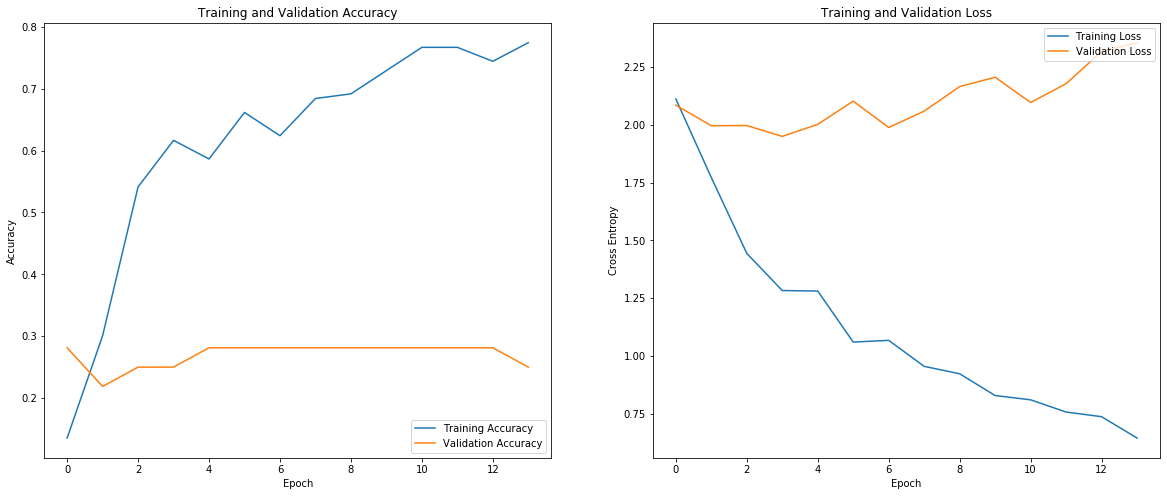

In [47]:
acc = trfr_model_history.history['accuracy']
val_acc = trfr_model_history.history['val_accuracy']

loss = trfr_model_history.history['loss']
val_loss = trfr_model_history.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

#### Takeaways from these plots

* This model performs worse than our simple model on the validation set
* We are using the same EarlyStopping and ModelCheckpoint callbacks for training which are set to monitor the `val_loss`
* imagenet weights for Resnet50V2 layers don't directly work with our data. We may need to retrain some layers of this model.
* Although the number of initial epochs are set to 100, but around `epoch=4` the *validation loss starts increasing* which indicates that the model is starting to overfit from that point onwards. The best model, at this point is saved.
* Not a good model to use in production

> **How to improve?**
> * add more data
> * *Transfer Learning* with Resnet50V2 architecture and fine-tuning the last few layers of the model
> * apply CAM and/or gradCAM to understand what is the model looking at in the images for making the prediction

### Fine Tuning the Transfer Learning model

In the previous experiment, the weights of the pre-trained network - ResNet50V2, were **NOT** updated during training. One way to improve the performance is to train (or fine-tune) the weights of the top layers of the pre-trained model when training the classifier. This will force the weights to be tuned from generic feature mappings to features associated specifically to the dataset.

#### Un-freeze the top layers

In [33]:
base_model.trainable = True # to allow the model layers to be trained again

In [34]:
# Let's take a look to see how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

Number of layers in the base model: 190


In [35]:
# Fine-tune starting from this layer onwards
fine_tune_at = 120 # after few iterations I figured that training the top 70 layers gives a good model

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#### Compile and train the model

In [44]:
trfr_fntn_model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

trfr_fntn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
trfr_fntn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 14343     
Total params: 23,579,143
Trainable params: 18,339,847
Non-trainable params: 5,239,296
_________________________________________________________________


We're training way more parameters this time as we un-freezed the top 70 layers. I am using the same early stopping and model checkpointing criteria as used before.

*Note: This model is using a learning rate of 1e-4 for optimization*

In [45]:
TRFR_FNTN_CALLBACK_MODEL_CHKPOINT = tf.keras.callbacks.ModelCheckpoint(filepath='/storage/models/usbills-trfr-fntn-model',
                                                             save_best_only=True,
                                                             verbose=1)

trfr_fntn_history = trfr_fntn_model.fit(train_generator,
                 epochs=TRFR_EPOCHS,
                 steps_per_epoch = STEPS_PER_EPOCH,
                 validation_data=valid_generator,
                 validation_steps=VALIDATION_STEPS,
                 callbacks=[TRFR_CALLBACK_EARLY_STOP, TRFR_FNTN_CALLBACK_MODEL_CHKPOINT])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 9 steps, validate for 2 steps
Epoch 1/100
8/9 [=========================>....] - ETA: 2s - loss: 0.2463 - accuracy: 0.9531
Epoch 00001: val_loss improved from inf to 23.78583, saving model to /storage/models/usbills-trfr-fntn-model
INFO:tensorflow:Assets written to: /storage/models/usbills-trfr-fntn-model/assets
9/9 [==============================] - 53s 6s/step - loss: 0.2221 - accuracy: 0.9549 - val_loss: 23.7858 - val_accuracy: 0.1250
Epoch 2/100
8/9 [=========================>....] - ETA: 2s - loss: 0.1154 - accuracy: 0.9658
Epoch 00002: val_loss improved from 23.78583 to 14.43949, saving model to /storage/models/usbills-trfr-fntn-model
INFO:tensorflow:Assets written to: /storage/models/usbills-trfr-fntn-model/assets
9/9 [==============================] - 51s 6s/step - loss: 0.1087 - accuracy: 0.9699 - val_loss: 14.4395 - val_accuracy: 0.1875
Epoch 3/100
8/9 [=========================>....] - ETA: 2s - loss: 0.0627 - accur

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the ResNet50V2 base model and training the classifier on top of it.

*Note: Some overfitting is good. As long as the validation loss keeps decreasing (validation accuracy keeps increasing), you should keep training the model.*

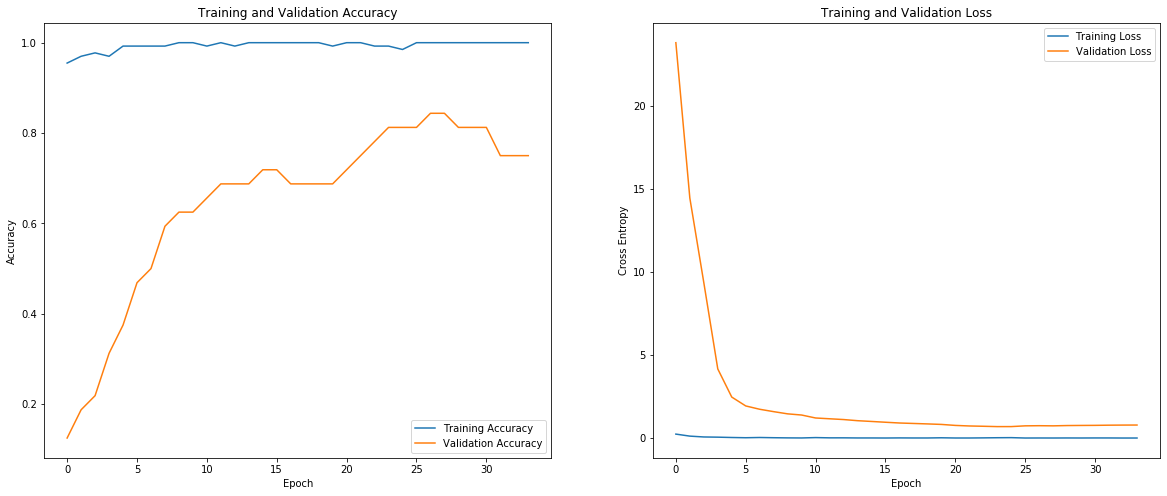

In [48]:
acc = trfr_fntn_history.history['accuracy']
val_acc = trfr_fntn_history.history['val_accuracy']

loss = trfr_fntn_history.history['loss']
val_loss = trfr_fntn_history.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

#### Takeaways from these plots

* This model is the best performing model by far. The validation accuracy reached `80%` and just look at that plot for validation loss improvement
* We are using the same EarlyStopping and ModelCheckpoint callbacks for training which are set to monitor the `val_loss`
* Retraining the last 70 layers of the Resnet50V2 model definitely helped quite a lot in improving the model performance.
* Although the number of initial epochs are set to 100, but around `epoch=24` the *validation loss starts increasing slowly* which indicates that the model is starting to overfit from that point onwards. The best model, at this point is saved.
* Good model :)

> **Further improvements?**
> * add more data
> * apply CAM and/or gradCAM to understand what is the model looking at in the images for making the prediction

### Conclusion

Using transfer learning is a neat technique in deep learning which helps in using the weights from a pre-trained model, applied on the current problem at hand. This works well because the initial layers of any model are just trying to identify the very basic features, which can also be used as a basis to help solve other similar problems. The top layers of the model, can then be fine-tuned to learn the specific representations from the problem at hand.

Furthermore, fine-tuning the model can make a significant difference on the model's performance. In the case of this model, after the start of fine-tuning, the validation accuracy started increasing and the validation loss started decreasing thereby giving a better model, which does a great job of recognizing US bills.

**Even with such a small amount of data, transfer learning combined with fine-tuning the top layers, really helped in training a good model.**